In [8]:
import os
import re

result_file_name_format = re.compile(r'K(\d+)W(\d+)D(\d+)T(\d+)')
result_files = list(filter(lambda file_name: result_file_name_format.match(file_name), os.listdir()))

def process_results_file(file_name):
    navigation_results = {}
    with open(file_name, 'r') as results_file:
        for line in results_file:
            kmer, query_result = line.strip().split(": ")
            count, out_edges = query_result.strip().split(" ")
            navigation_results[kmer] = (int(count), int(out_edges, 2))
    
    return navigation_results

ks = set()
results = []
for file in result_files:
    k = int(result_file_name_format.match(file).group(1))
    ks.add(k)
    W = int(result_file_name_format.match(file).group(2))
    D = int(result_file_name_format.match(file).group(3))
    presence_threshold = int(result_file_name_format.match(file).group(4))
    navigation_results = process_results_file(file)
    results.append({
        "k": k,
        "W": W,
        "D": D,
        "presence_threshold": presence_threshold,
        "navigation_results": navigation_results
    })

In [21]:
kmer_counts_reads = {}
with open('reads.txt', 'r') as reads_file:
    for k in ks:
        kmer_counts_reads[k] = {}
        for line in reads_file:
            for i in range(len(line) - k):
                kmer = line[i:i+k]
                if kmer not in kmer_counts_reads[k]:
                    kmer_counts_reads[k][kmer] = 0
                kmer_counts_reads[k][kmer] += 1

In [35]:
for result in results:
    visited_kmers = set(result['navigation_results'])
    actual_kmers = set(kmer_counts_reads[result['k']])
    found_kmers = set(filter(lambda kmer: result['navigation_results'][kmer][0] > result['presence_threshold'], visited_kmers))
    false_positives = found_kmers - actual_kmers
    false_negatives = actual_kmers - found_kmers
    result['visited_count'] = len(visited_kmers)
    result['found_count'] = len(found_kmers)
    result['false_positives'] = false_positives
    result['false_negatives'] = false_negatives
    result['false_positive_count'] = len(false_positives)
    result['false_negative_count'] = len(false_negatives)
    result['false_positive_rate'] = len(false_positives) / len(found_kmers)
    result['false_negative_rate'] = len(false_negatives) / len(actual_kmers)

In [36]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.head()

,k,W,D,presence_threshold,navigation_results,false_positives,false_negatives,false_positive_count,false_negative_count,false_positive_rate,false_negative_rate,visited_count,found_count
0,7,1000,8,1,"{'TTGCAAC': (381, 12), 'AGTCAGT': (452, 15), '...","{CCCTATT, TGCGCTG, CCTTATA, GTTGGGC, GGATTTT, ...",{},8554,0,0.532661,0.000000,16102,16059
1,7,1000,2,1,"{'TTGCAAC': (885, 15), 'AGTCAGT': (476, 15), '...","{CCCTATT, CCTTATA, TGCGCTG, GTTGGGC, GGATTTT, ...",{},8853,0,0.541203,0.000000,16367,16358
2,7,7000,1,80,"{'TACACAT': (519, 15), 'TTTTCTT': (464, 5), 'T...","{CAAGGCC, AACACGA, AAATGGA, CCCGCTG, TTGCGCC, ...","{CTCAGAG, CTGGACA, TGGCCTG, CTTACGA, TTGTGGG, ...",876,1799,0.133090,0.239707,9104,6582
3,7,10000,16,40,"{'GGTGCAA': (315, 10), 'CCGAATC': (292, 15), '...",{},"{GTCACAG, TTTCAAT, CGATGCT, GCCCAAA, AGGTATC, ...",0,67,0.000000,0.008927,7438,7438
4,7,8000,4,40,"{'GGTGCAA': (315, 10), 'CCGAATC': (292, 15), '...","{TGGCTGC, ACGTATT, ACGTCAT, GGAGCCC, AACGCCG, ...","{GTCACAG, TTTCAAT, CGATGCT, GCCCAAA, AGGTATC, ...",38,63,0.005080,0.008394,7747,7480


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
mpl.style.use('seaborn')

In [38]:
filtered_df = results_df.loc[results_df['presence_threshold'] == 40]
filtered_df = filtered_df.sort_values(['D', 'W'])

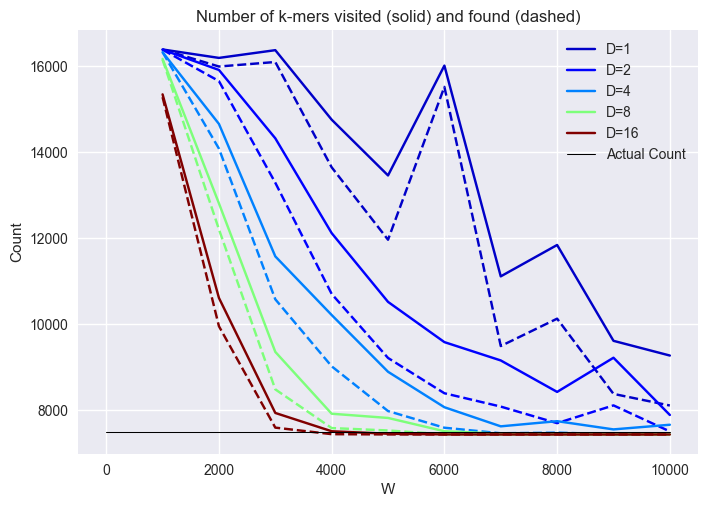

In [75]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

for D, group in filtered_df.groupby('D'):
    plt.plot(group['W'], group['visited_count'], label=f'D={D}', color=colors[D])
    plt.plot(group['W'], group['found_count'], '--', color=colors[D])

plt.plot([0, filtered_df['W'].max()], [len(kmer_counts_reads[filtered_df['k'].min()]), len(kmer_counts_reads[filtered_df['k'].min()])], color='black', label='Actual Count', linewidth=0.75)
plt.legend()
plt.xlabel('W')
plt.ylabel('Count')
plt.title('Number of k-mers visited (solid) and found (dashed)')
plt.show()

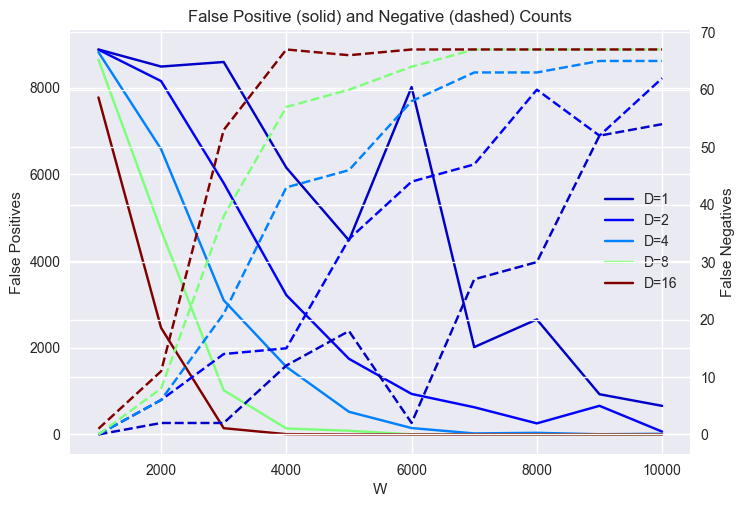

In [80]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby('D'):
    ax1.plot(group['W'], group['false_positive_count'], label=f'D={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_count'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Counts')
plt.show()

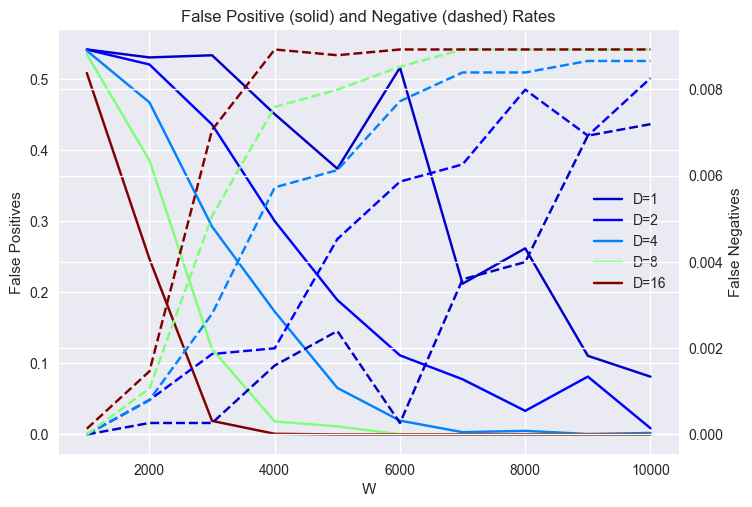

In [81]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby('D'):
    ax1.plot(group['W'], group['false_positive_rate'], label=f'D={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_rate'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Rates')
plt.show()